This notebook explores some of the same concepts and data visualization tools used in other notebooks in this repo, but does so on a very specific genre called 'MathRock'

First we grab our SpotifyAPI class, so when we need to make API calls, we can

In [4]:
import base64
import datetime
from urllib.parse import urlencode

import requests

#Follows Spotify's "Implicit Grant" Authorization flow
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    authorization_url = "https://accounts.spotify.com/authorize"
    
    #external functions ("public")
    

    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')

    def get_playlist(self, _id):
        return self.get_resource(_id, resource_type='playlists')

    def get_playlist_tracks(self, _id):
        return self.get_resource(_id, resource_type='playlists', addendum='tracks')

    def get_track_features(self, _id):
        return self.get_resource(_id, resource_type='audio-features')

    def get_track_analysis(self, _id):
      return self.get_resource(_id, resource_type='audio-analysis') 

    def search(self, query=None, operator=None, operator_query=None, search_type='artist', limit=20 ):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q": query, "type": search_type.lower(), "limit": str(limit)})
        return self.base_search(query_params)

    #generic api request, accepts the full endpoint string

    def generic_get(self, endpoint):
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)
            if r.status_code == 429:
              print('Retry after ' + str(r.headers['Retry-After']) + ' seconds')
              raise Exception("You are requesting too much data, retry after " + str(r.headers['Retry-After']) + ' seconds')
            return {}
        return r.json()

    def generic_post(self, endpoint):
        headers = self.get_resource_header()
        r = requests.post(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)
            return {}
        return r.json()

    def generic_put(self, endpoint):
        headers = self.get_resource_header()
        r = requests.put(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)

            
    #internal functions ("private")


    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1', addendum=''):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}/{addendum}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    
    
    def base_search(self, query_params): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()

    #new functions for user functions

    def get_current_user(self):
        endpoint = f"https://api.spotify.com/v1/me"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    def get_current_user_recently_played(self):
        endpoint = f"https://api.spotify.com/v1/me/player/recently-played"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    def get_current_user_top(self, top_type='tracks', time_range='medium_term'):
        #endpoint = f"https://api.spotify.com/v1/me/top/{top_type}?limit=50&time_range{time_range}"
        endpoint = f"https://api.spotify.com/v1/me/top/{top_type}?time_range={time_range}&limit=50"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)
            return {}
        return r.json()

    def get_user(self, user):
        endpoint = f"https://api.spotify.com/v1/users/{user}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

import webbrowser
import json

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time

#Initializing spotify API and defining some important constants
client_id = ""
client_secret = ""

spotify = SpotifyAPI(client_id, client_secret)
indices = {'resource_types':['tracks','artists'],'time_frames':['short_term','medium_term', 'long_term']}



In [5]:
artistNames = ["Algernon Cadwallader",
               "American Football",
               "Cap'n Jazz",
               "Chinese Football",
               "Chon",
               #"Colour",
               "Covet",
               "Clever Girl",
               #"Dads",
               "Delta Sleep",
               "Don Cabellero",
               "Elephant Gym",
               "empire! empire! (i was a lonely estate)",
               "Enemies",
               "Floral",
               "Foster Parents",
               "Giraffes? Giraffes!",
               "Glocca Morra",
               #"Hella",
               "Holding Patterns",
               "Invalids",
               #"LITE",
               "Look Mexico",
               "Maps & Atlases",
               #"Meet Me in St. Louis",
               #"Mountains",
               "Parker Projection",
               #"Piglet",
               "Plini",
               "Polyphia",
               #"Rooftops",
               #"Sawce",
               "standards",
               "Stephen Hazel",
               "Strawberry Girls",
               "Tangled Hair",
               "Tera Melos",
               "tide/edit",
               "Tiny Moving Parts",
               "toe",
               "Totorro", 
               "TTNG",
               "Via Luna",
               #"Wavey", 
               "Yvette Young"
               ]
artistFull = []
artistFull.append(spotify.get_artist("686v1kwTGE84qdWD5y9t13")) #mountains
artistFull.append(spotify.get_artist("51KBxhZnpafTjP0cKulltO")) #Sawce
artistFull.append(spotify.get_artist("2yWSSjhvrYXwKwWalVbt57")) #Wavey
artistFull.append(spotify.get_artist("0TF6B1cp2QZXLE0NjhTMT9")) #LITE
artistFull.append(spotify.get_artist("507WKf85fzZkH5W2c61m10")) #Meet me in st. louis
artistFull.append(spotify.get_artist("4HBe2DscKcmFAjL1ml3Lx6")) #Rooftops
artistFull.append(spotify.get_artist("1v3s3UWR9gxbG1roBfviHq")) #Colour
artistFull.append(spotify.get_artist("7eMopflZIkcPF4refj6MNU")) #Piglet
artistFull.append(spotify.get_artist("2OUGTXNFUe4WwC4CWpvIal")) #Dads
artistFull.append(spotify.get_artist("1n861RIk6CTAWncgHR9UHg")) #Hella



In [6]:

for artist in artistNames:
  res = spotify.search(query=artist, search_type='artist', limit=1)
  artistFull.append(res['artists']['items'][0])

artistFull

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/686v1kwTGE84qdWD5y9t13'},
  'followers': {'href': None, 'total': 2151},
  'genres': [],
  'href': 'https://api.spotify.com/v1/artists/686v1kwTGE84qdWD5y9t13',
  'id': '686v1kwTGE84qdWD5y9t13',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/ab6761610000e5eb18013081eb0dfa9b640d7f52',
    'width': 640},
   {'height': 320,
    'url': 'https://i.scdn.co/image/ab6761610000517418013081eb0dfa9b640d7f52',
    'width': 320},
   {'height': 160,
    'url': 'https://i.scdn.co/image/ab6761610000f17818013081eb0dfa9b640d7f52',
    'width': 160}],
  'name': 'Mountains',
  'popularity': 15,
  'type': 'artist',
  'uri': 'spotify:artist:686v1kwTGE84qdWD5y9t13'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/51KBxhZnpafTjP0cKulltO'},
  'followers': {'href': None, 'total': 5521},
  'genres': ['instrumental math rock'],
  'href': 'https://api.spotify.com/v1/artists/51KBxhZnpafTjP0cKulltO',
  'id': '51KBxhZnpaf

In [7]:
count = 0
for artist in artistFull:
  count +=1
  print(count)
  time.sleep(0.1)
  related_artist_ids = []
  similar_artists = spotify.generic_get('https://api.spotify.com/v1/artists/' + artist['id'] +'/related-artists')
  for similar_artist in similar_artists['artists']:
    related_artist_ids.append({'name':similar_artist['name'],'id':similar_artist['id']})
  artist['similar_artists'] = related_artist_ids


#REPLACING ALL $ WITH S because graphing below doesn;t like it
for artist in artistFull:
  artist['name'] = artist['name'].replace("$", "S")
  for sim_artist in artist['similar_artists']:
    sim_artist['name'] = sim_artist['name'].replace("$", "S")



for artist in artistFull:
  print(artist)

print('\n=====================================================================\n')



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
{'external_urls': {'spotify': 'https://open.spotify.com/artist/686v1kwTGE84qdWD5y9t13'}, 'followers': {'href': None, 'total': 2151}, 'genres': [], 'href': 'https://api.spotify.com/v1/artists/686v1kwTGE84qdWD5y9t13', 'id': '686v1kwTGE84qdWD5y9t13', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab6761610000e5eb18013081eb0dfa9b640d7f52', 'width': 640}, {'height': 320, 'url': 'https://i.scdn.co/image/ab6761610000517418013081eb0dfa9b640d7f52', 'width': 320}, {'height': 160, 'url': 'https://i.scdn.co/image/ab6761610000f17818013081eb0dfa9b640d7f52', 'width': 160}], 'name': 'Mountains', 'popularity': 15, 'type': 'artist', 'uri': 'spotify:artist:686v1kwTGE84qdWD5y9t13', 'similar_artists': [{'name': 'Stephen Hazel', 'id': '4ybACWcR6JC9gVgOWXTMGT'}, {'name': 'Invalids', 'id': '1RdlYzlj42Mq7tO5y1o4Cz'}, {'name': 'Foster Parents', 'id': '2iIeDi3R7VF4ddOV2f7kqM'}

['Mountains', 'Sawce', 'Wavey', 'LITE', 'Meet Me in St. Louis', 'Rooftops', 'Colour', 'Piglet', 'Dads', 'Hella', 'Algernon Cadwallader', 'American Football', "Cap'n Jazz", 'Chinese Football', 'Chon', 'Covet', 'Clever Girl', 'Delta Sleep', 'Don Caballero', 'Elephant Gym', 'empire! empire! (i was a lonely estate)', 'Enemies', 'Floral', 'Foster Parents', 'Giraffes? Giraffes!', 'Glocca Morra', 'Holding Patterns', 'Invalids', 'Look Mexico', 'Maps & Atlases', 'Parker Projection', 'Plini', 'Polyphia', 'standards', 'Stephen Hazel', 'Strawberry Girls', 'Tangled Hair', 'Tera Melos', 'tide/edit', 'Tiny Moving Parts', 'toe', 'Totorro', 'TTNG', 'Via Luna', 'Yvette Young']
45
[('Mountains', 'Stephen Hazel'), ('Mountains', 'Invalids'), ('Mountains', 'Foster Parents'), ('Mountains', 'Colour'), ('Mountains', 'standards'), ('Mountains', 'Delta Sleep'), ('Mountains', 'Floral'), ('Mountains', 'TTNG'), ('Mountains', 'Chinese Football'), ('Mountains', 'Clever Girl'), ('Mountains', 'Via Luna'), ('Mountains',

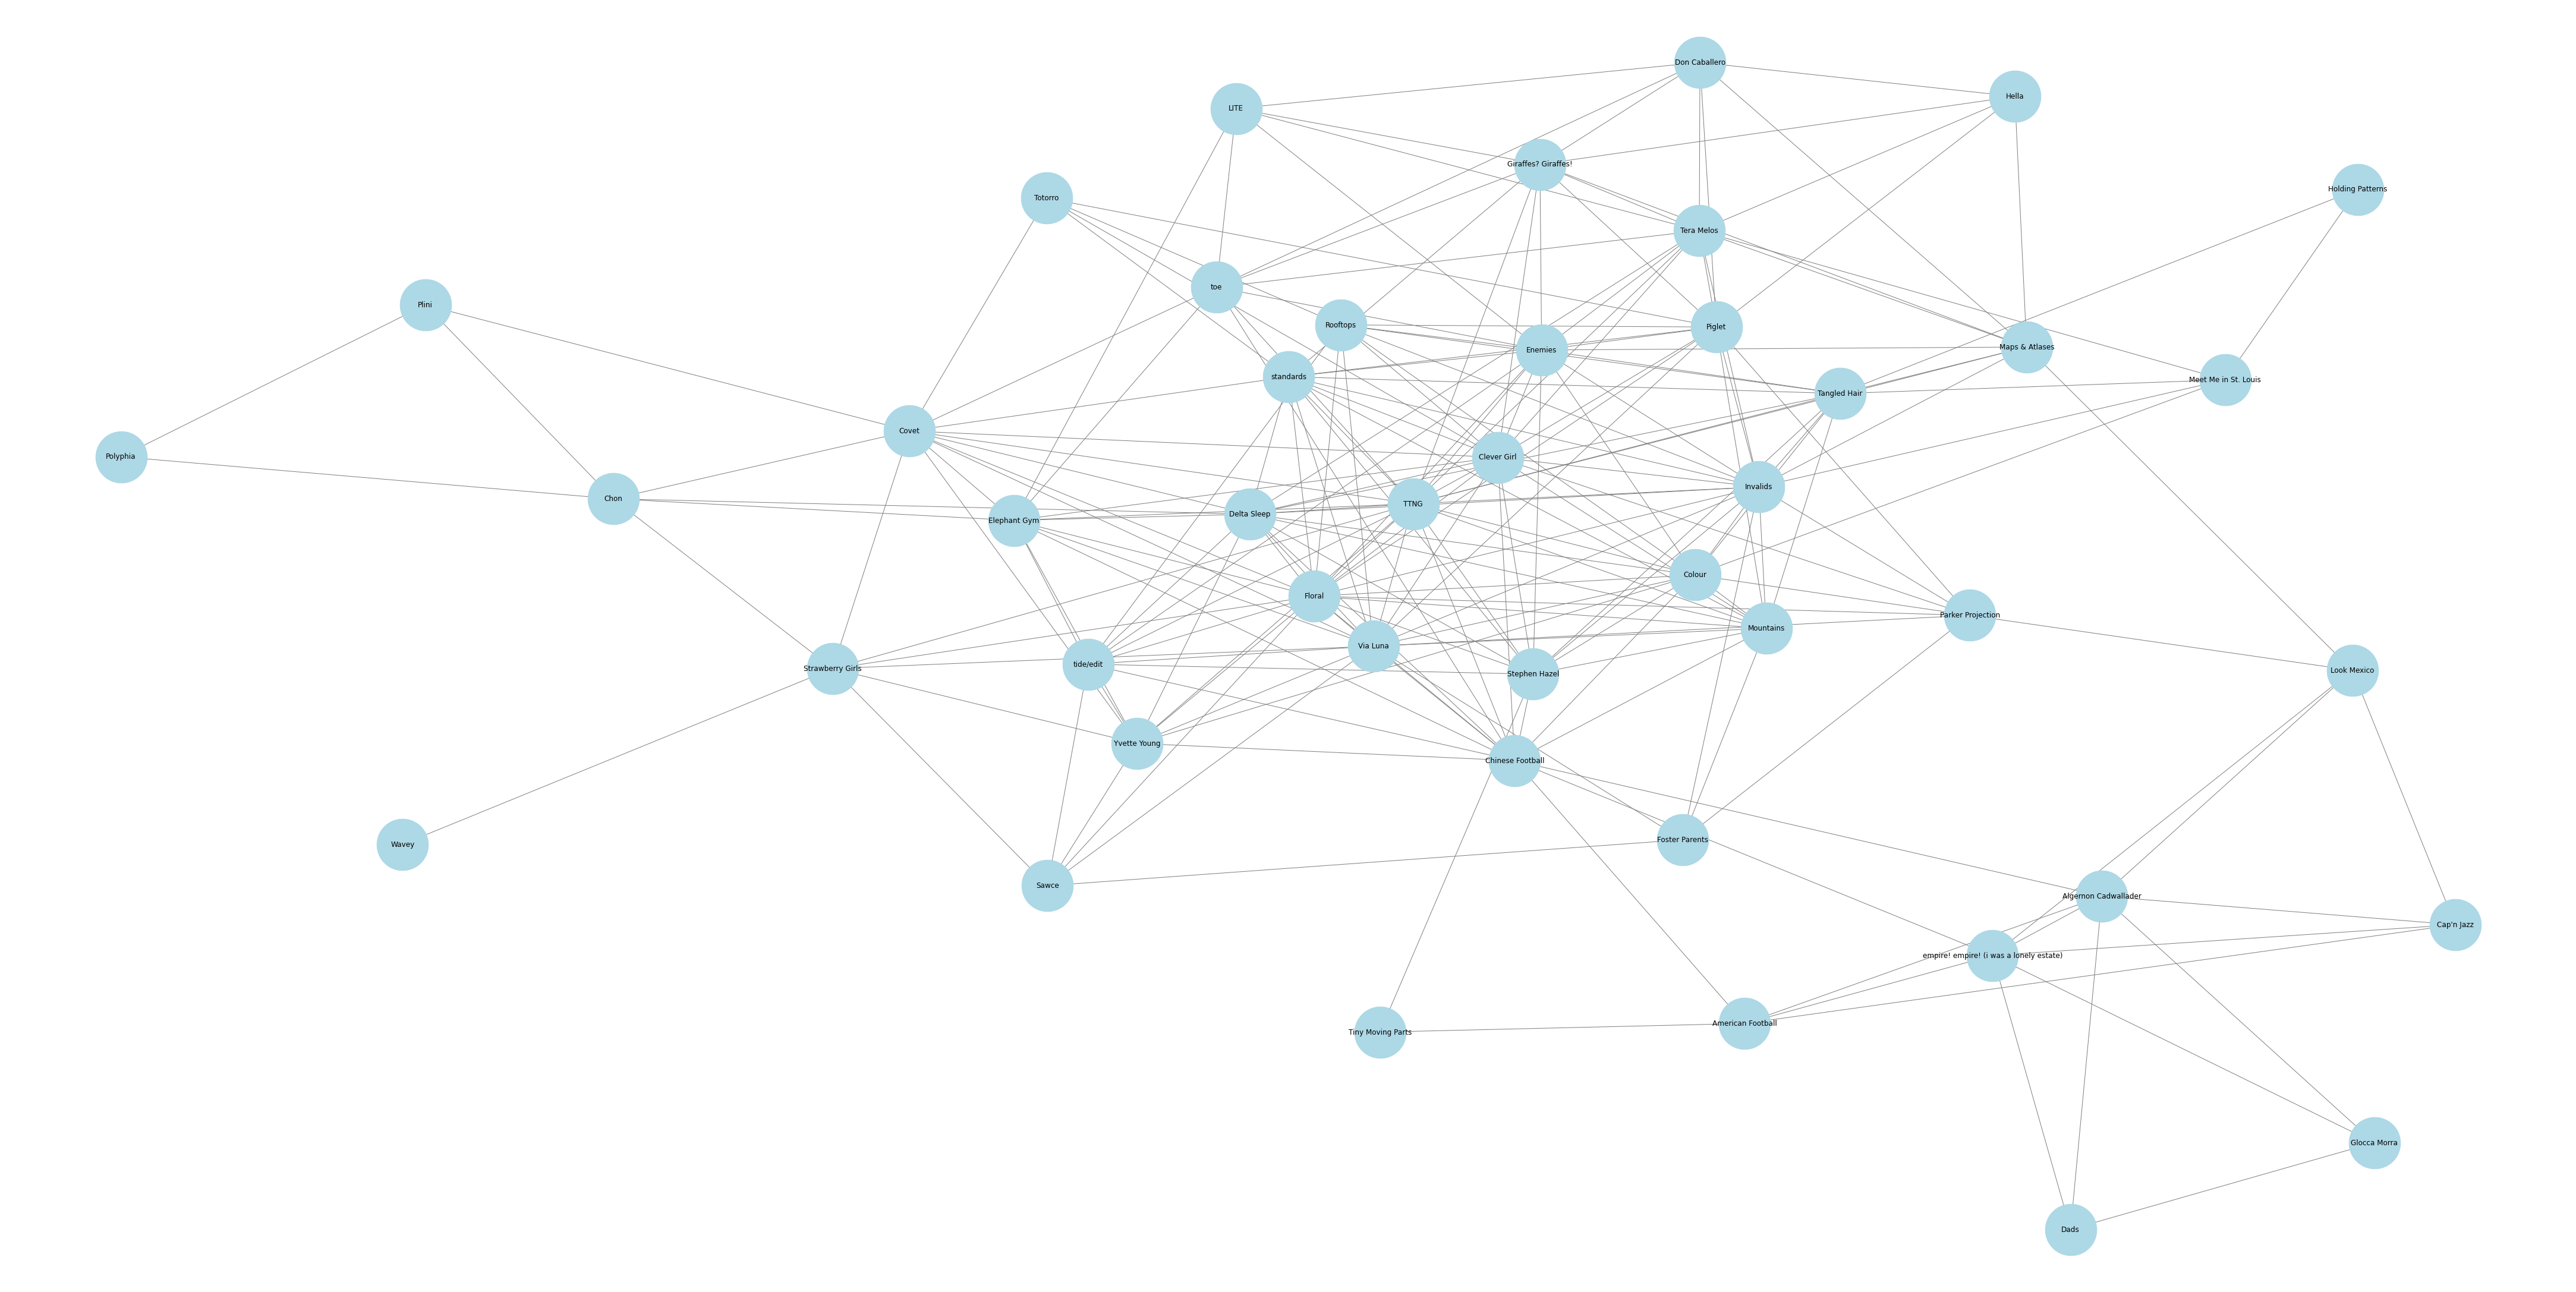

In [9]:
artist_map = []

for artist in artistFull:
  item = {'name': artist['name'],  'id': artist['id']}
  edges = []
  for similar_artist in artist['similar_artists']:
    for artist_2 in artistFull:
      if artist_2['id'] == similar_artist['id']:
        edges.append({'name': artist_2['name'], 'id':artist_2['id']})
  item['edges'] = edges
  artist_map.append(item)

tier2artists = [];
for artist in artistFull:
  item = {'name': artist['name'],  'id': artist['id']}
  #edges = []
  for similar_artist in artist['similar_artists']:
    for artist_2 in artistFull:
      for similar_artist_2 in artist_2['similar_artists']:
        if artist['id'] != artist_2['id'] and similar_artist['id'] != artist_2['id'] and artist['id'] != similar_artist_2['id']:
          if similar_artist_2['id'] == similar_artist['id']:
            tier2artists.append({'name': similar_artist_2['name'], 'id':similar_artist_2['id'], 'artist_1':artist['name'], 'artist_2':artist_2['name']})

artist_map

import networkx as nx
G=nx.Graph()
G

for artist in artist_map:
  G.add_node(artist['name']) #change back to name

print(G.nodes())

print(len(G.nodes()))

for artist in artist_map:
  for edge in artist['edges']:
    graph_edge = (artist['name'], edge['name'])#change back to name
    G.add_edge(*graph_edge)

print(G.edges())
len(G.edges())


# pos=nx.nx.nx_pydot.graphviz_layout(G)
# #pos=nx.nx.nx_pydot.pydot_layout(G)

# #pos = nx.drawing.layout.spring_layout(G)

# plt.figure()

# nx.draw_networkx_nodes(G,pos,
#                        nodelist=common_node_list,
#                        node_color='lightblue',
#                        node_size = 1000,
#                        with_labels = True,
#                    alpha=0.8)
# nx.draw_networkx_labels(G, pos, labels=common_node_dict)

# nx.draw_networkx_nodes(G,pos,
#                        nodelist=user_1_node_list,
#                        node_color='lightblue',
#                        node_size = user_1_node_sizes,
#                        with_labels = True,
#                    alpha=0.8)
# nx.draw_networkx_labels(G, pos, labels=user_1_node_dict)

# nx.draw_networkx_nodes(G,pos,
#                        nodelist=user_2_node_list,
#                        node_color='pink',
#                        node_size = user_2_node_sizes,
#                        with_labels = True,
#                    alpha=0.8)
# nx.draw_networkx_labels(G, pos, labels=user_2_node_dict)



# nx.draw_networkx_edges(G,pos,alpha=0.5)

# nx.draw_networkx_nodes(G,pos,
#                        nodelist=user_2_node_list,
#                        node_color='r',
#                        with_labels = True,
#                    alpha=0.8)

# nx.draw_networkx_nodes(G,pos,
#                        nodelist=common_node_list,
#                        node_color='purple',
#                        with_labels = True,
#                    alpha=0.8)

# nx.draw_networkx_edges(G,pos,alpha=0.5)
# # nx.draw(G,pos = nx.nx_pydot.graphviz_layout(G), with_labels = True,node_color='lightblue', edge_color='gray')

# plt.rcParams["figure.figsize"] = (40,20)
# # plt.savefig("avery_medium_term.png") # save as png
# plt.show() # display

nx.draw(G,pos = nx.nx_pydot.graphviz_layout(G), with_labels = True,node_color='lightblue', edge_color='gray', node_size=7500)

plt.rcParams["figure.figsize"] = (60,30)
# plt.savefig("avery_medium_term.png") # save as png
plt.show() # display


dimensions: 23 x 2


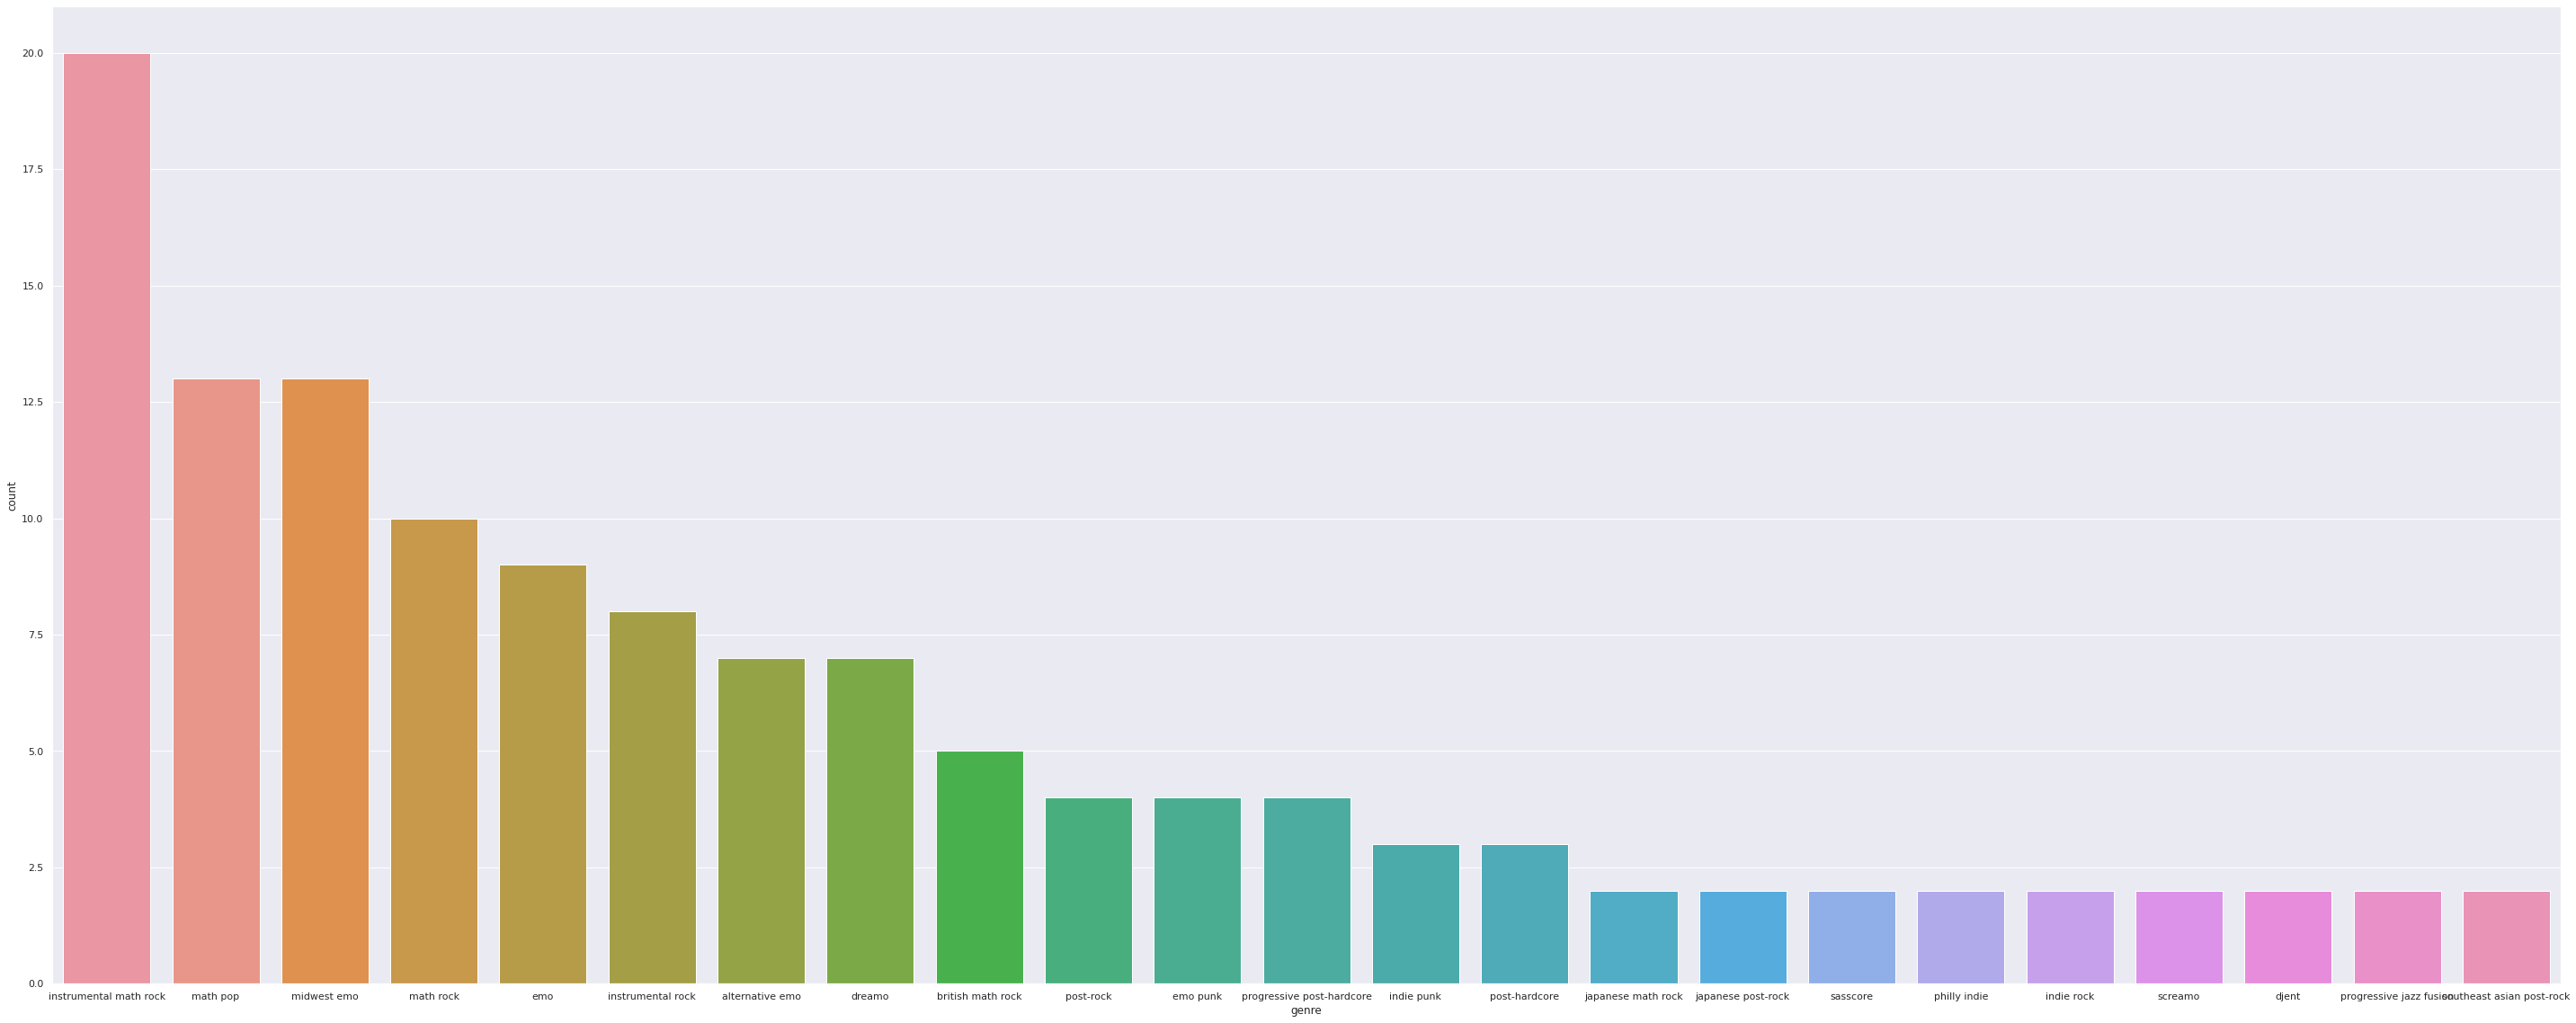

In [10]:
genre_dict = {}


for artist in artistFull:
  for genre in artist['genres']:
    if genre in genre_dict:
      genre_dict[genre] = genre_dict[genre] + 1
    else:
      genre_dict[genre] = 1

genre_dict
sort_genre_dict = sorted(genre_dict.items(), key=lambda x: x[1], reverse=True)

sort_genre_dict_filtered = []

for item in sort_genre_dict:
  if not item[1] <= 1:
    sort_genre_dict_filtered.append(item)


print("dimensions: " + str(len(sort_genre_dict_filtered)) + " x " + str(len(sort_genre_dict_filtered[0])))
df = pd.DataFrame(sort_genre_dict_filtered, columns=['genre', 'count'])
sns.set(style="darkgrid")


fig_dims = (50, 20)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='genre', y='count', data=df, ax=ax)




# print("dimensions: " + str(len(sort_genre_dict)) + " x " + str(len(sort_genre_dict[0])))
# df = pd.DataFrame(sort_genre_dict, columns=['genre', 'count'])
# sns.set(style="darkgrid")


# fig_dims = (50, 20)
# fig, ax = plt.subplots(figsize=fig_dims)
# sns.barplot(x='genre', y='count', data=df, ax=ax)


In [11]:
genre_dict

{'alternative emo': 7,
 'anthem emo': 1,
 'austindie': 1,
 'brighton indie': 1,
 'british math rock': 5,
 'bubblegrunge': 1,
 'chicago indie': 1,
 'chicago punk': 1,
 'chinese indie': 1,
 'chinese post-rock': 1,
 'derby indie': 1,
 'djent': 2,
 'dreamo': 7,
 'emo': 9,
 'emo punk': 4,
 'emocore': 1,
 'experimental rock': 1,
 'french post-rock': 1,
 'indie punk': 3,
 'indie rock': 2,
 'instrumental math rock': 20,
 'instrumental post-rock': 1,
 'instrumental rock': 8,
 'japanese emo': 1,
 'japanese jazz fusion': 1,
 'japanese math rock': 2,
 'japanese post-rock': 2,
 'math pop': 13,
 'math rock': 10,
 'midwest emo': 13,
 'new jersey indie': 1,
 'nintendocore': 1,
 'noise rock': 1,
 'oxford indie': 1,
 'philly indie': 2,
 'pinoy indie': 1,
 'post-hardcore': 3,
 'post-rock': 4,
 'progressive jazz fusion': 2,
 'progressive post-hardcore': 4,
 'sacramento indie': 1,
 'san diego indie': 1,
 'sasscore': 2,
 'screamo': 2,
 'shanghai indie': 1,
 'southeast asian post-rock': 2,
 'taiwan indie': 1

In [12]:
tier2artistsdict = {}

for artist in artistFull:
  for similar_artist in artist['similar_artists']:
    sim_artist_already_in_main_list = False
    for artist_2 in artistFull:
      if similar_artist['id'] == artist_2['id']:
        sim_artist_already_in_main_list = True
    if not sim_artist_already_in_main_list:
      if similar_artist['id'] in tier2artistsdict:
        tier2artistsdict[similar_artist['id']]['count'] += 1
        tier2artistsdict[similar_artist['id']]['connected_artists'].append(artist['name'])
      else:
        tier2artistsdict[similar_artist['id']] = {}
        tier2artistsdict[similar_artist['id']]['name'] = similar_artist['name']
        tier2artistsdict[similar_artist['id']]['id']= similar_artist['id']
        tier2artistsdict[similar_artist['id']]['count'] = 1
        tier2artistsdict[similar_artist['id']]['connected_artists'] = [artist['name']]

tier2artistsdict

{'02eZaSqr4w3FTDeabE8KjG': {'connected_artists': ['Invalids'],
  'count': 1,
  'id': '02eZaSqr4w3FTDeabE8KjG',
  'name': 'Girlfriends'},
 '02k39cTG2ZzfOpBT51o2sV': {'connected_artists': ['Meet Me in St. Louis',
   'Tangled Hair'],
  'count': 2,
  'id': '02k39cTG2ZzfOpBT51o2sV',
  'name': 'Mutiny On The Bounty'},
 '06eexGweIG9BWxxUVSttxR': {'connected_artists': ['Mountains',
   'Foster Parents',
   'Parker Projection'],
  'count': 3,
  'id': '06eexGweIG9BWxxUVSttxR',
  'name': 'Just Neighbors'},
 '06kjmifIXkcvdDRZEH6uEZ': {'connected_artists': ['Dads'],
  'count': 1,
  'id': '06kjmifIXkcvdDRZEH6uEZ',
  'name': 'Deer Leap'},
 '06ybtH5XIOkGqkpDR2LKvM': {'connected_artists': ['Totorro'],
  'count': 1,
  'id': '06ybtH5XIOkGqkpDR2LKvM',
  'name': 'The Shaking Sensations'},
 '08W0DyaiHaB4UffeoImMPS': {'connected_artists': ['Foster Parents'],
  'count': 1,
  'id': '08W0DyaiHaB4UffeoImMPS',
  'name': 'Zoo Strategies'},
 '0AFUfewUv31E8EtQPAD3l5': {'connected_artists': ['Tiny Moving Parts'],
  'c

In [13]:
def getNumConnectedArtists(artist):
  return artist["count"]

tier2artistslist = []
for key, val in tier2artistsdict.items():
  tier2artistslist.append({'name': val['name'], 'id': val['id'], 'count': val['count']})


tier2artistslist.sort(key=getNumConnectedArtists, reverse=True)

for artist in tier2artistslist:
  print(artist['name'] + ' : ' + str(artist['count']))

Pretend : 18
Monobody : 17
Hikes : 15
Stage Kids : 15
Vasudeva : 12
Tom's Story : 11
a picture of her : 10
Eternity Forever : 10
Feed Me Jack : 10
The Most : 9
You Slut! : 9
3nd : 7
By The End Of Tonight : 7
Snowing : 7
Everyone Everywhere : 7
JYOCHO : 7
paranoid void : 7
Sleepy Dog : 6
Adebisi Shank : 6
The Redneck Manifesto : 6
Faraquet : 6
Prawn : 6
CSTVT : 6
Jakub Zytecki : 5
Six Gallery : 5
Dikembe : 5
Joie De Vivre : 5
Bygones : 5
Good Game : 4
mouse on the keys : 4
Three Trapped Tigers : 4
Dowsing : 4
Hightide Hotel : 4
Old Gray : 4
You Blew It! : 4
Football, Etc. : 4
The World Is A Beautiful Place & I Am No Longer Afraid To Die : 4
Battles : 4
Sithu Aye : 4
Intervals : 4
Mestís : 4
Just Neighbors : 3
Sea in the Sky : 3
I Built the Sky : 3
jizue : 3
Brontide : 3
Tubelord : 3
Cinemechanica : 3
Rob Ford Explorer : 3
Brave Bird : 3
Crash Of Rhinos : 3
Zach Hill : 3
OWLS : 3
A Great Big Pile of Leaves : 3
Mineral : 3
The Promise Ring : 3
Braid : 3
Arch Echo : 3
David Maxim Micic : 3

In [14]:
for artist in artist_map:
  print(artist['name'] + " : "+ str(len(artist['edges'])))

Mountains : 13
Sawce : 6
Wavey : 1
LITE : 6
Meet Me in St. Louis : 2
Rooftops : 10
Colour : 9
Piglet : 12
Dads : 3
Hella : 3
Algernon Cadwallader : 4
American Football : 5
Cap'n Jazz : 2
Chinese Football : 12
Chon : 5
Covet : 13
Clever Girl : 13
Delta Sleep : 10
Don Caballero : 3
Elephant Gym : 9
empire! empire! (i was a lonely estate) : 4
Enemies : 7
Floral : 9
Foster Parents : 3
Giraffes? Giraffes! : 7
Glocca Morra : 3
Holding Patterns : 2
Invalids : 9
Look Mexico : 3
Maps & Atlases : 9
Parker Projection : 8
Plini : 1
Polyphia : 1
standards : 11
Stephen Hazel : 12
Strawberry Girls : 3
Tangled Hair : 5
Tera Melos : 7
tide/edit : 8
Tiny Moving Parts : 1
toe : 8
Totorro : 0
TTNG : 13
Via Luna : 8
Yvette Young : 9


In [15]:
def getPopularity(artist):
  return artist["popularity"]

artistFull.sort(key=getPopularity, reverse=True)

for artist in artistFull:
  print(artist['name'] + " : " + str(artist['popularity']))


Polyphia : 63
Chon : 56
American Football : 54
Plini : 54
Delta Sleep : 50
Tiny Moving Parts : 50
toe : 50
Strawberry Girls : 49
Covet : 48
TTNG : 46
Yvette Young : 45
Elephant Gym : 42
Cap'n Jazz : 39
LITE : 38
Algernon Cadwallader : 38
Totorro : 38
Sawce : 37
Chinese Football : 37
Glocca Morra : 37
Hella : 36
Don Caballero : 36
empire! empire! (i was a lonely estate) : 36
Floral : 36
Clever Girl : 35
Giraffes? Giraffes! : 35
Maps & Atlases : 35
Tera Melos : 35
standards : 34
Via Luna : 33
Dads : 32
Enemies : 32
Tangled Hair : 31
tide/edit : 28
Colour : 27
Piglet : 27
Rooftops : 25
Invalids : 25
Look Mexico : 25
Wavey : 23
Meet Me in St. Louis : 18
Mountains : 15
Foster Parents : 13
Holding Patterns : 8
Parker Projection : 5
Stephen Hazel : 5
